# COVID-19 Individual Based Modelling 

Basic COVID-19 individual-based model where infection occurs with probability

$P = e^{-I/{R_0}}$

$I$ : intervention level

$R_0$ : base infection level

Infections last for 10 days with infections granting immunity from reinfection for 365 days.

There is a base chance of 1% for a re-emergence of the disease through the random infecting of a member of the population if there are no present infections

### Library imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### People

In [2]:
class Person:
    """Base individual for COVID-19 model"""
    
    def __init__(self):
        # Infection
        self.infected   = False
        self.t_infected = 0
        
        #Immunity 
        self.immune     = False
        self.t_immune   = 0
    
    
    def infect(self):
        # Do  not reinfect
        if self.infected or self.immune:
            return
        self.infected   = True
        self.immune     = True
    
    def progress(self):
        
        # Progress infection if occured but reset after 10 days
        if self.infected:
            self.t_infected += 1
            if self.t_infected >= 10:
                self.t_infected = 0
                self.infected = False
                
        # Progress immunity if occured but reset after 365 days           
        if self.immune:
            self.t_immune += 1
            if self.t_immune >= 365:
                self.t_immune = 0
                self.immune   = False

### Simulation class

In [3]:
class Simulation:
    """Main simulation wrapper"""
    
    def __init__(self, pop_size = 100, seed_pop = 1):
        
         # Initialise numpy rng
        np.random.seed()
        
        # Simulation variables
        self.pop_size = pop_size
        self.seed_pop = seed_pop
        
        # Create population
        self.population = [Person() for i in range(self.pop_size)]
        
        # Infect seed population
        infected_indices = np.random.randint(0,self.pop_size,self.seed_pop)
        for i in infected_indices:
            self.population[i].infect()
        
        # Track statistics
        self.total_infections        = []
        self.current_infection_level = []
        self.immunity_level          = []
    
    
    def run(self, time=100, daily_interactions=100, intervention_level=1, r_0=1):        
        
        # Simulation parameters
        self.time = np.arange(0,time,1)
        self.daily_interactions = daily_interactions
        
        # Precompute probability
        infection_probability = np.exp(np.divide(np.multiply(-1.0, intervention_level),r_0))
    
        total_infection_counter = 0
    
        # Simulation loop
        for day in self.time:
                
            for interaction in range(daily_interactions):

                # Select two random people
                person_1, person_2 = np.random.randint(0,self.pop_size,2)

                # If both are immune then select a new interaction 
                # Infected individuals are automatically immune
                if(self.population[person_1].immune and self.population[person_2].immune):
                    continue

                # If neither are infected then also generate a new interaction
                if(not self.population[person_1].infected and not self.population[person_2].infected):
                    continue

                # If random number [0,1) falls under probability criteria then an infection occurs
                if (np.random.random() < infection_probability):
                        # Infection will only take place if not already infected/immune
                        self.population[person_1].infect()
                        self.population[person_2].infect()
                        total_infection_counter += 1

            # Update statistics
            self.total_infections.append(total_infection_counter)
            self.current_infection_level.append(len([person for person in self.population if person.infected]))
            self.immunity_level.append(len([person for person in self.population if person.immune]))
    
            # Generate endemic infection
            if (self.current_infection_level[-1]==0):
                if np.random.random() < 0.01:
                    self.population[np.random.randint(0,self.pop_size)].infect()
    

            # Progress each person's infection
    
            # N.B This could be made faster by only tracking infected
            # or immune individuals but simplicity is the goal here
            for person in self.population:
                person.progress()
                
            

### Simulation control

Simulate a population of 100 for a total of 1000 days with decreasing intervention level

In [4]:
sim = Simulation(pop_size = 100, seed_pop = 1)
sim.run(time=90, daily_interactions=100,  intervention_level=7, r_0=2.5)
sim.run(time=90, daily_interactions=100,  intervention_level=6.75, r_0=2.5)
sim.run(time=90, daily_interactions=100,  intervention_level=6.5, r_0=2.5)
sim.run(time=90, daily_interactions=100,  intervention_level=6.25, r_0=2.5)
sim.run(time=730, daily_interactions=100, intervention_level=5, r_0=2.5)

### Plotting

Show current infection and immunity levels with 10% critical care facility box shown

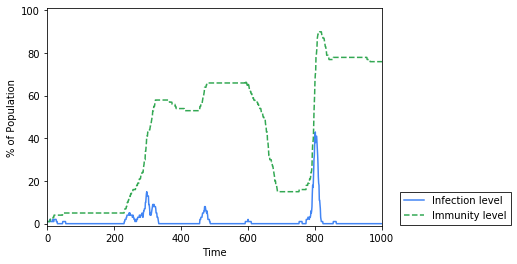

In [5]:
import matplotlib.patches as patches

flat_red   = '#ea4335'
flat_blue  = '#4285f4'
flat_green = '#33a853'

fig = plt.figure()
ax = plt.axes(xlim=(-1, 1000), ylim=(-1,101))
plt.xlabel('Time')
plt.ylabel('% of Population')



ax.plot(np.multiply(100, np.divide(sim.current_infection_level, sim.pop_size)), color=flat_blue, linestyle='-', lw=1.5, label='Infection level')
ax.plot(np.multiply(100, np.divide(sim.immunity_level, sim.pop_size)), color=flat_green, linestyle='--', lw=1.5, label='Immunity level')

rect = patches.Rectangle((0,-1),1000,11,linewidth=1.5,edgecolor=flat_red,facecolor=flat_red,alpha=0.25)
#ax.add_patch(rect)

#ax.axes.xaxis.set_ticklabels([])
plt.legend(title='', loc='upper right', bbox_to_anchor=(1.4, 0.18), edgecolor='black', fancybox=False)
plt.show()